# Data preparation

## Data description
- instant: record index
- dteday: date
- season: season (1:winter, 2:spring, 3:summer, 4:fall)
- yr: year
- mnth: month (1 to 12)
- holiday: whether day is holiday or not
- weekday: day of the week
- workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
- weathersit: weather situation:
    1: Clear, Few clouds, Partly cloudy, Partly cloudy
    2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp: Temperature
- atemp: Feeling temperature
- hum: Humidity
- windspeed: Wind speed
- leaflets: Number of distributed leaflets (for marketing purposes)
- price reduction: Day with price reduction (yes = 1, no = 0)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

**From WP 1**

- Identified missing values in 'Season' & 'Humidity'
- identified invalid values in 'Weekday', 'Windspeed' & 'Humidity'
- recommended to remove some problematic features (atemp,instant)
- pointed out outliers in cnt & casual

**From my analysis**
1. Missing Values
-- season: Has 73 missing values.
-- hum: Has 40 missing values.
- Action: Both columns will require imputation (e.g., filling with mode or mean) before modeling.

2. Outliers
    - Data Errors: Impossible values were found and must be corrected.
        - weekday: Has some -1.0 values.
        - windspeed: Has a -1.0 value.
    - Statistical Outliers: casual and cnt have extreme high-value outliers. These outliers are the direct cause of the severe skew in these features.

3. Features to be Transformed
    - Categorical Features: season, mnth, weekday, and weathersit must be one-hot encoded so models don't treat them as ordered numbers.
    - dteday: The columns yr, mnth, and weekday are already extracted from it, but maybe the day of the month can have a predictive value and should be extracted from it.

4. Features to be Removed (Feature Selection)
    - casual and registered: Must be removed. They add up to cnt and represent target leakage.
    - atemp: Must be removed. It's redundant due to a 0.99 correlation with temp.
    - instant: Must be removed. It's a useless record index.
    - dteday: Must be removed, but only after extracting a new day_of_month feature from it.

5. Other Insights
    - Missing Category: The weathersit category 4 (Heavy Rain) is defined but never occurs in the data.
    - Imbalanced Data: holiday, workingday, and price reduction are all highly imbalanced (one category is very rare), which is expected but important for modeling.
    - Good Predictors: temp, yr, and leaflets show the strongest correlation with the cnt target and will be key features.


## Import libraries

In [221]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Load data

In [210]:
# Load training and testing datasets with ; separator
df_train = pd.read_csv('BikeRentalDaily_train.csv', sep=';')
df_test = pd.read_csv('BikeRentalDaily_test.csv', sep=';')

print("Training Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)

df_train.head()

Training Data Shape: (600, 18)
Testing Data Shape: (132, 18)


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
0,154,03.06.2011,2.0,0,6,0,5,1,1,24.8000,0.587133,53.12505,0.253121,991,0,898,4414,5312
1,685,15.11.2012,4.0,1,11,0,4,1,2,12.8667,0.324492,93.06255,0.152987,601,0,320,5125,5445
2,368,03.01.2012,1.0,1,1,0,2,1,1,6.0000,0.126275,66.18750,0.365671,549,0,89,2147,2236
3,472,16.04.2012,2.0,1,4,1,1,0,1,26.5667,0.614925,84.25005,0.284829,740,0,1198,5172,6370
4,442,17.03.2012,1.0,1,3,0,-1,0,2,20.5667,0.505046,113.37495,0.110704,773,1,3155,4681,7836


## Solve critical issues 

### Solve missing values in 'season'


In [211]:
# 1, Detect season boundaries
# Convert 'dteday' to datetime objects and sort
df_train['dteday'] = pd.to_datetime(df_train['dteday'], format='%d.%m.%Y')
df_test['dteday'] = pd.to_datetime(df_test['dteday'], format='%d.%m.%Y')
df_train = df_train.sort_values('dteday').reset_index(drop=True)
# Identify season transitions (using only rows where season is known)
df_known = df_train.dropna(subset=['season']).copy()

# Create a marker that increments every time the season value changes
df_known['season_block'] = (df_known['season'] != df_known['season'].shift(1)).cumsum()
# Get the first and last date for each season block
season_transitions = df_known.groupby(['season_block', 'season'])['dteday'].agg(['min', 'max']).reset_index()
season_transitions.columns = ['block', 'season', 'start_date', 'end_date']
print("Detected Season Boundaries:")
print(season_transitions)

Detected Season Boundaries:
   block  season start_date   end_date
0      1     1.0 2011-01-02 2011-03-20
1      2     2.0 2011-03-21 2011-06-20
2      3     3.0 2011-06-21 2011-09-22
3      4     4.0 2011-09-23 2011-12-20
4      5     1.0 2011-12-21 2012-03-20
5      6     2.0 2012-03-22 2012-06-20
6      7     3.0 2012-06-21 2012-09-22
7      8     4.0 2012-09-23 2012-12-20
8      9     1.0 2012-12-21 2012-12-31


In [212]:
# 2. Apply the boundaries to fill missing 'season' values
def assign_season(date):
    # Convert input date to 'MMDD' string
    mmdd = date.strftime('%m%d')
    
    # Season 2 (Spring): March 21/22 to June 20
    if "0321" <= mmdd <= "0620":
        return 2.0    
    # Season 3 (Summer): June 21 to September 22
    elif "0621" <= mmdd <= "0922":
        return 3.0    
    # Season 4 (Fall): September 23 to December 20
    elif "0923" <= mmdd <= "1220":
        return 4.0    
    # Season 1 (Winter): Everything else (Covers Dec 21 - Dec 31 AND Jan 01 - Mar 20)
    else:
        return 1.0

# Apply to train and test
df_train.loc[df_train['season'].isna(), 'season'] = df_train[df_train['season'].isna()]['dteday'].apply(assign_season)
df_test.loc[df_test['season'].isna(), 'season'] = df_test[df_test['season'].isna()]['dteday'].apply(assign_season)

print("Missing values after boundary-based fill:")
print(f"Train: {df_train['season'].isna().sum()}")
print(f"Test: {df_test['season'].isna().sum()}")

Missing values after boundary-based fill:
Train: 0
Test: 0


### Solve Invalid values and missing values in 'hum'

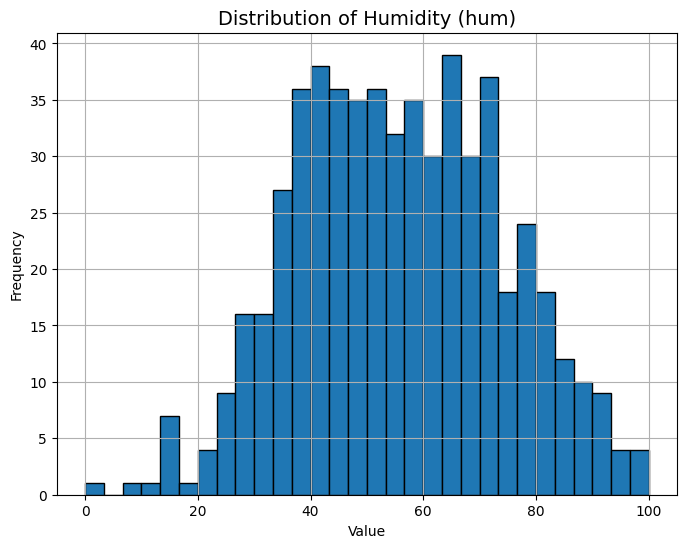

In [213]:
# 1. Initialize
scaler = MinMaxScaler(feature_range=(0, 100))

# 2. Fit the scaler to learn the min/max from the data
scaler.fit(df_train[['hum']])

# 3. Scale both sets
df_train['hum'] = scaler.transform(df_train[['hum']])
df_test['hum'] = scaler.transform(df_test[['hum']]) 

# Plotting only the 'hum' attribute
df_train.hist(column='hum', bins=30, figsize=(8, 6), edgecolor='black')

# Adding labels and title for clarity
plt.title('Distribution of Humidity (hum)', fontsize=14)
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

In [214]:
# 4, Replace missing values with the median
df_train['hum'] = df_train['hum'].fillna(df_train['hum'].median())
df_test['hum'] = df_test['hum'].fillna(df_test['hum'].median())

print(f"Train: {df_train['hum'].isna().sum()}")
print(f"Test: {df_test['hum'].isna().sum()}")

Train: 0
Test: 0


### Solve invalid values in 'weekday'

In [215]:
# Fix 'weekday' using the 'dteday' column 
def fix_weekday(row):
    if row['weekday'] <= 0.0 or row['weekday'] >= 8.0:
        return row['dteday'].weekday()
    return row['weekday']

df_train['weekday'] = df_train.apply(fix_weekday, axis=1)
df_test['weekday'] = df_test.apply(fix_weekday, axis=1)

### Solve invalid values in 'windspeed'

In [216]:
# Remove rows with invalid windspeed (-1.0)
initial_train_size = len(df_train)
initial_test_size = len(df_test)
df_train = df_train[df_train['windspeed'] != -1.0].copy()

# Verification
print(f"Rows removed from Train: {initial_train_size - len(df_train)}")
print(f"Rows removed from Test: {initial_test_size - len(df_test)}")
print(f"Minimum windspeed now: {df_train['windspeed'].min()}")

Rows removed from Train: 4
Rows removed from Test: 0
Minimum windspeed now: 0.0223917


### Solve target leakage problem

In [217]:
# Drop 'casual' and 'registered' to prevent target leakage
df_train = df_train.drop(columns=['casual', 'registered'])
df_test = df_test.drop(columns=['casual', 'registered'])

print("Remaining columns in training set:")
print(df_train.columns.tolist())

Remaining columns in training set:
['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'leaflets', 'price reduction', 'cnt']


### Remove unnecessary columns

In [218]:
# 1. Final Cleaning: Drop redundant columns
cols_to_drop = ['atemp', 'instant', 'dteday']
df_train = df_train.drop(columns=cols_to_drop)
df_test = df_test.drop(columns=cols_to_drop)

## Baseline model v1

In [223]:
# 1. Split the initial df_train_final into Training and Validation sets
# We'll use 20% for validation and set a random_state for reproducibility
train_set, val_set = train_test_split(df_train, test_size=0.2, random_state=42)
# 2. Separate Features (X) and Target (y) for all three sets
# Training Set (used to fit the model)
X_train = train_set.drop(columns=['cnt'])
y_train = train_set['cnt']
# Validation Set (used to evaluate performance during training)
X_val = val_set.drop(columns=['cnt'])
y_val = val_set['cnt']

# 3. Train the model on the TRAINING set
model = LinearRegression()
model.fit(X_train, y_train)
# 4. Evaluate on the VALIDATION set
y_val_pred = model.predict(X_val)
print("--- Validation Model Performance ---")
print(f"R-squared (Val): {r2_score(y_val, y_val_pred):.4f}")
print(f"RMSE (Val): {np.sqrt(mean_squared_error(y_val, y_val_pred)):.2f}")

--- Validation Model Performance ---
R-squared (Val): 0.3461
RMSE (Val): 2747.46


## Another data preparation steps

In [ ]:
# One-hot encoding for weathersit
df_train_encoded = pd.get_dummies(df_train_clean, columns=['weathersit'], drop_first=True)
df_test_encoded = pd.get_dummies(df_test_clean, columns=['weathersit'], drop_first=True)

In [ ]:
df_train_encoded.head()


,season,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,leaflets,price reduction,cnt,weathersit_2,weathersit_3
0,1.0,0,1,0,6,0,13.7667,78.757251,0.160446,755,0,985,True,False
1,1.0,0,1,0,6,0,14.5391,64.769438,0.248539,837,1,801,True,False
2,1.0,0,1,0,1,1,7.8546,31.781978,0.248309,829,0,1349,False,False
3,1.0,0,1,0,2,1,8.0000,51.303431,0.160296,734,0,1562,False,False
4,1.0,0,1,0,3,1,9.0783,31.741702,0.186900,745,0,1600,False,False


In [ ]:
df_test_encoded.head()

,season,yr,mnth,holiday,weekday,workingday,temp,hum,windspeed,leaflets,price reduction,cnt,weathersit_2,weathersit_3
0,4.0,0,10,0,3,1,19.3667,67.870448,0.148642,605,0,3894,True,False
1,2.0,1,4,0,1,1,17.3565,40.331106,0.312139,518,0,5936,False,False
2,4.0,1,11,0,6,0,13.0000,45.565606,0.179729,766,0,5629,False,False
3,4.0,0,12,0,0,1,9.5333,55.469976,0.063450,739,0,3310,False,False
4,4.0,0,10,0,2,1,21.3000,65.480644,0.110087,463,0,4748,True,False


In [ ]:
# 2. Applying Cyclic Encoding
def apply_cyclic_encoding(df):
    # Season (1-4)
    df['season_sin'] = np.sin(2 * np.pi * df['season'] / 4)
    df['season_cos'] = np.cos(2 * np.pi * df['season'] / 4)    
    # Month (1-12)
    df['mnth_sin'] = np.sin(2 * np.pi * df['mnth'] / 12)
    df['mnth_cos'] = np.cos(2 * np.pi * df['mnth'] / 12)    
    # Weekday (0-6)
    df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)    
    # Drop original columns after encoding
    return df.drop(columns=['season', 'mnth', 'weekday'])

df_train_encoded = apply_cyclic_encoding(df_train_encoded)
df_test_encoded = apply_cyclic_encoding(df_test_encoded)

## Baseline model v2

In [225]:
# 1. Split the initial df_train_final into Training and Validation sets
# We'll use 20% for validation and set a random_state for reproducibility
train_set_encoded, val_set_encoded = train_test_split(df_train_encoded, test_size=0.2, random_state=42)
# 2. Separate Features (X) and Target (y) for all three sets
# Training Set (used to fit the model)
X_train_encoded = train_set_encoded.drop(columns=['cnt'])
y_train_encoded = train_set_encoded['cnt']
# Validation Set (used to evaluate performance during training)
X_val_encoded = val_set_encoded.drop(columns=['cnt'])
y_val_encoded = val_set_encoded['cnt']

# 3. Train the model on the TRAINING set
model2 = LinearRegression()
model2.fit(X_train_encoded, y_train_encoded)
# 4. Evaluate on the VALIDATION set
y_val_pred_encoded = model2.predict(X_val_encoded)
print("--- Validation Model Performance ---")
print(f"R-squared (Val): {r2_score(y_val_encoded, y_val_pred_encoded):.4f}")
print(f"RMSE (Val): {np.sqrt(mean_squared_error(y_val_encoded, y_val_pred_encoded)):.2f}")

--- Validation Model Performance ---
R-squared (Val): 0.3491
RMSE (Val): 2741.23


# Save the prepared datasets

In [ ]:
# 1. Save the processed dataframes to CSV
# df_train.to_csv('BikeRentalDaily_train_prepared.csv', index=False)
# df_test.to_csv('BikeRentalDaily_test_prepared.csv', index=False)
# print("Saved files:")
# print("- BikeRentalDaily_train_prepared.csv")
# print("- BikeRentalDaily_test_prepared.csv")

# 2. Save the final processed (and encoded) dataframes to CSV
# df_train_encoded.to_csv('BikeRentalDaily_train_prepared_encoded.csv', index=False)
# df_test_encoded.to_csv('BikeRentalDaily_test_prepared_encoded.csv', index=False)
# print("Saved files:")
# print("- BikeRentalDaily_train_prepared_encoded.csv")
# print("- BikeRentalDaily_test_prepared_encoded.csv")

Saved files:
- BikeRentalDaily_train_prepared.csv
- BikeRentalDaily_test_prepared.csv
Saved files:
- BikeRentalDaily_train_prepared_encoded.csv
- BikeRentalDaily_test_prepared_encoded.csv
